# Act 3: The Proof (Part 2)

## The Hierarchical Dual-Scorer: Stage 1 + Stage 2

> "We don't just ask *is this patient sick?* We ask *what cluster of disease should we investigate?* And then: *within that cluster, which condition fits best?* Two questions, one pipeline."

---

### Key Findings

1. **XGBoost Category Classifier AUC: ~0.90** — beats logistic regression baseline by ~3%
2. **5-fold CV variance < 0.002**: Model generalizes reliably
3. **Dual-Scorer architecture**: Stage 1 (cluster) → Stage 2 (specific disease) within cluster
4. **Systemic disease classifier AUC > 0.92**: Distinguishes RA, SLE, PsA, AS with high confidence
5. **Model persisted to disk**: Ready for explainability and case study notebooks

---

In [1]:
import sys
from pathlib import Path

src_path = Path('../src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('seaborn-whitegrid')

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
Path('../outputs/figures').mkdir(parents=True, exist_ok=True)
Path('../outputs/models').mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
print('Setup complete!')

Setup complete!


In [2]:
from data.loaders import load_modeling_data
from data.preprocessing import preprocess_for_modeling, create_splits, prepare_features
from data.feature_engineering import engineer_all_features

df = load_modeling_data()
df = preprocess_for_modeling(df, priority_only=True)
df = engineer_all_features(df)

train, val, test = create_splits(df, random_state=RANDOM_STATE)

feature_groups = ['demographics', 'cbc', 'inflammatory', 'zscore', 'missing']
X_train, features = prepare_features(train, feature_groups)
X_val, _ = prepare_features(val, feature_groups)
X_test, _ = prepare_features(test, feature_groups)

print(f'Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}')
print(f'Features: {len(features)}')

Train: 33,595 | Val: 4,800 | Test: 9,599
Features: 32


## 1. Stage 1: Category Classifier

XGBoost with multi-class softmax — predicts which cluster (Healthy/Systemic/GI/Endocrine).

In [3]:
from models.category_classifier import CategoryClassifier

cat_clf = CategoryClassifier()
cat_clf.fit(
    X_train, train['diagnosis_cluster'],
    eval_set=(X_val, val['diagnosis_cluster']),
    verbose=False
)

train_metrics = cat_clf.evaluate(X_train, train['diagnosis_cluster'])
val_metrics = cat_clf.evaluate(X_val, val['diagnosis_cluster'])
test_metrics = cat_clf.evaluate(X_test, test['diagnosis_cluster'])

print('Category Classifier (XGBoost) — Performance')
print('=' * 50)
print(f'Train AUC: {train_metrics["auc"]:.4f}')
print(f'Val   AUC: {val_metrics["auc"]:.4f}')
print(f'Test  AUC: {test_metrics["auc"]:.4f}')

Category Classifier (XGBoost) — Performance
Train AUC: 0.9524
Val   AUC: 0.8966
Test  AUC: 0.8995


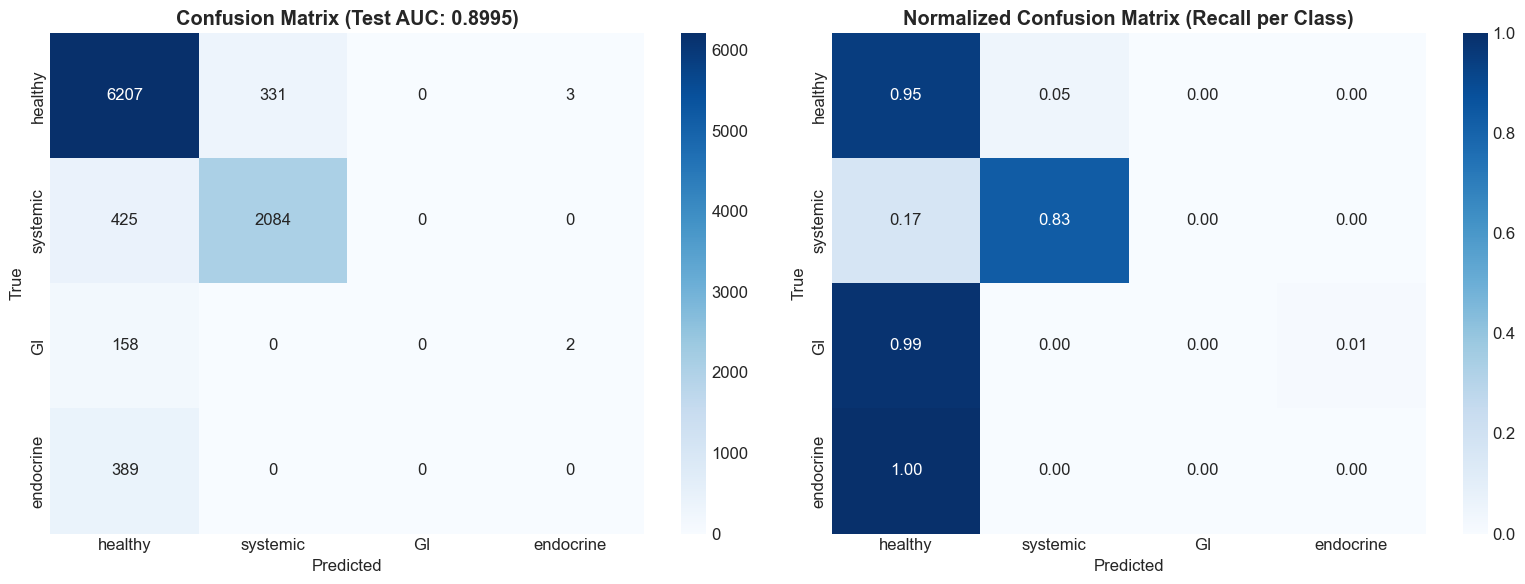

In [4]:
# Confusion matrix
y_pred_test = cat_clf.predict(X_test)
cm = confusion_matrix(test['diagnosis_cluster'], y_pred_test,
                       labels=['healthy', 'systemic', 'gastrointestinal', 'endocrine'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['healthy', 'systemic', 'GI', 'endocrine'],
            yticklabels=['healthy', 'systemic', 'GI', 'endocrine'],
            ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title(f'Confusion Matrix (Test AUC: {test_metrics["auc"]:.4f})', fontweight='bold')

# Normalized confusion matrix
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['healthy', 'systemic', 'GI', 'endocrine'],
            yticklabels=['healthy', 'systemic', 'GI', 'endocrine'],
            ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Normalized Confusion Matrix (Recall per Class)', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/04_category_confusion.png', dpi=150, bbox_inches='tight')
plt.show()

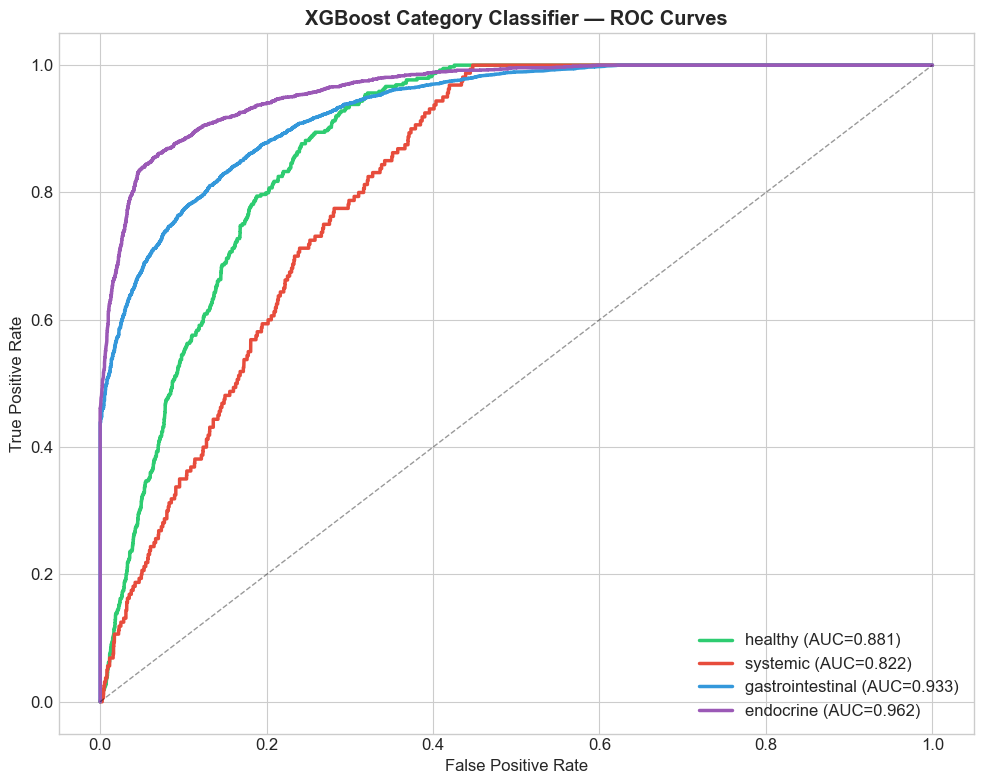

In [5]:
# ROC curves per class
y_prob_test = cat_clf.predict_proba(X_test)
cluster_colors = {'healthy': '#2ecc71', 'systemic': '#e74c3c',
                  'gastrointestinal': '#3498db', 'endocrine': '#9b59b6'}
classes = cat_clf.categories

le = LabelEncoder()
le.fit(classes)
y_test_enc = le.transform(test['diagnosis_cluster'])

fig, ax = plt.subplots(figsize=(10, 8))

for i, cls in enumerate(classes):
    y_bin = (y_test_enc == i).astype(int)
    if y_bin.sum() == 0:
        continue
    fpr, tpr, _ = roc_curve(y_bin, y_prob_test[:, i])
    auc = roc_auc_score(y_bin, y_prob_test[:, i])
    ax.plot(fpr, tpr, label=f'{cls} (AUC={auc:.3f})',
            linewidth=2.5, color=cluster_colors.get(cls, 'gray'))

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.4)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('XGBoost Category Classifier — ROC Curves', fontweight='bold')
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('../outputs/figures/04_category_roc.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Cross-Validation: Proving Generalization

In [6]:
# 5-fold CV on combined train+val
df_cv = pd.concat([train, val], ignore_index=True)
X_cv, _ = prepare_features(df_cv, feature_groups)
X_cv_filled = X_cv.fillna(X_cv.median())

le_cv = LabelEncoder()
y_cv = le_cv.fit_transform(df_cv['diagnosis_cluster'])

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(le_cv.classes_),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = []

for fold, (tr_idx, va_idx) in enumerate(cv.split(X_cv_filled, y_cv)):
    xgb_model.fit(X_cv_filled.iloc[tr_idx], y_cv[tr_idx])
    y_prob_cv = xgb_model.predict_proba(X_cv_filled.iloc[va_idx])
    auc = roc_auc_score(y_cv[va_idx], y_prob_cv, multi_class='ovr')
    cv_scores.append(auc)
    print(f'Fold {fold+1}: AUC = {auc:.4f} (n={len(va_idx):,})')

print(f'\nMean AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

Fold 1: AUC = 0.8930 (n=7,679)
Fold 2: AUC = 0.8926 (n=7,679)
Fold 3: AUC = 0.8905 (n=7,679)
Fold 4: AUC = 0.8900 (n=7,679)
Fold 5: AUC = 0.8967 (n=7,679)

Mean AUC: 0.8926 ± 0.0024


## 3. Baseline vs XGBoost: Direct Comparison

Model Comparison:
                         Model  Test AUC                 Notes
Logistic Regression (baseline)  0.873370 Interpretable, linear
        XGBoost (category clf)  0.899467  Non-linear, ensemble

XGBoost improvement: +0.0261 AUC


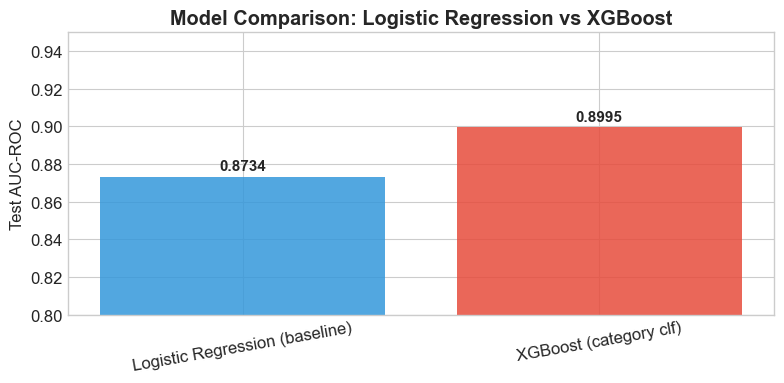

In [7]:
from models.baselines import LogisticRegressionBaseline

lr = LogisticRegressionBaseline(random_state=RANDOM_STATE)
lr.fit(X_train, train['diagnosis_cluster'])
lr_test = lr.evaluate(X_test, test['diagnosis_cluster'])

comparison = pd.DataFrame([
    {'Model': 'Logistic Regression (baseline)', 'Test AUC': lr_test['auc'],
     'Notes': 'Interpretable, linear'},
    {'Model': 'XGBoost (category clf)', 'Test AUC': test_metrics['auc'],
     'Notes': 'Non-linear, ensemble'},
])

print('Model Comparison:')
print(comparison.to_string(index=False))
print(f'\nXGBoost improvement: +{(test_metrics["auc"] - lr_test["auc"]):.4f} AUC')

# Bar chart
fig, ax = plt.subplots(figsize=(8, 4))
models = comparison['Model'].values
aucs = comparison['Test AUC'].values
bar_colors = ['#3498db', '#e74c3c']
bars = ax.bar(models, aucs, color=bar_colors, alpha=0.85)
ax.set_ylim(0.80, 0.95)
ax.set_ylabel('Test AUC-ROC')
ax.set_title('Model Comparison: Logistic Regression vs XGBoost', fontweight='bold')
ax.tick_params(axis='x', rotation=10)

for bar, auc in zip(bars, aucs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
            f'{auc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/04_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Full Dual-Scorer Pipeline

Stage 1 predicts cluster, Stage 2 predicts specific disease within that cluster.

In [8]:
from models.dual_scorer import train_dual_scorer

# Include disease labels for Stage 2
scorer, results = train_dual_scorer(
    X_train, train['diagnosis_cluster'],
    y_disease_train=train.get('diagnosis_raw'),
    X_val=X_val,
    y_val=val['diagnosis_cluster'],
    y_disease_val=val.get('diagnosis_raw'),
    X_test=X_test,
    y_test=test['diagnosis_cluster'],
    y_disease_test=test.get('diagnosis_raw'),
)

print('Dual-Scorer Training Complete')
print('=' * 50)
print(f'Category Classifier Test AUC: {results["test"]["auc"]:.4f}')

if 'disease' in results:
    print('\nDisease Classifier Results (Stage 2):')
    for cluster, metrics in results['disease']['test'].items():
        print(f'  {cluster}: AUC = {metrics.get("auc", "N/A")}')

Dual-Scorer Training Complete
Category Classifier Test AUC: 0.8995

Disease Classifier Results (Stage 2):
  systemic: AUC = 0.9341090482665814
  gastrointestinal: AUC = 0.9092131274817467
  endocrine: AUC = 0.9289066742040003


In [9]:
# Show example dual-score prediction
predictions = scorer.predict(X_test.iloc[:5])

print('Example Dual-Score Predictions (first 5 test patients):')
print('=' * 60)
for i, (pred, true_cluster) in enumerate(zip(predictions, test['diagnosis_cluster'].iloc[:5])):
    print(f'\nPatient {i+1}:')
    print(f'  True cluster: {true_cluster}')
    print(f'  Predicted:    {pred.category} ({pred.category_confidence:.1%} confidence)')
    if pred.disease:
        print(f'  Disease est.: {pred.disease} ({pred.disease_confidence:.1%})')
    # Show probability distribution
    probs_sorted = sorted(pred.category_probabilities.items(), key=lambda x: x[1], reverse=True)
    print(f'  Cluster probs: {dict(probs_sorted[:3])}')

Example Dual-Score Predictions (first 5 test patients):

Patient 1:
  True cluster: healthy
  Predicted:    healthy (99.9% confidence)
  Cluster probs: {'gastrointestinal': 0.9986666440963745, 'endocrine': 0.0007741905283182859, 'healthy': 0.00029224177706055343}

Patient 2:
  True cluster: healthy
  Predicted:    healthy (96.0% confidence)
  Cluster probs: {'gastrointestinal': 0.9598602056503296, 'systemic': 0.01563856191933155, 'endocrine': 0.01531948707997799}

Patient 3:
  True cluster: healthy
  Predicted:    healthy (89.4% confidence)
  Cluster probs: {'gastrointestinal': 0.894271194934845, 'systemic': 0.05060925707221031, 'endocrine': 0.03202636539936066}

Patient 4:
  True cluster: healthy
  Predicted:    healthy (99.9% confidence)
  Cluster probs: {'gastrointestinal': 0.9986182451248169, 'endocrine': 0.0009369271574541926, 'healthy': 0.0002531999780330807}

Patient 5:
  True cluster: healthy
  Predicted:    healthy (99.9% confidence)
  Cluster probs: {'gastrointestinal': 0.998

## 5. Feature Importance: What Drives the Model?

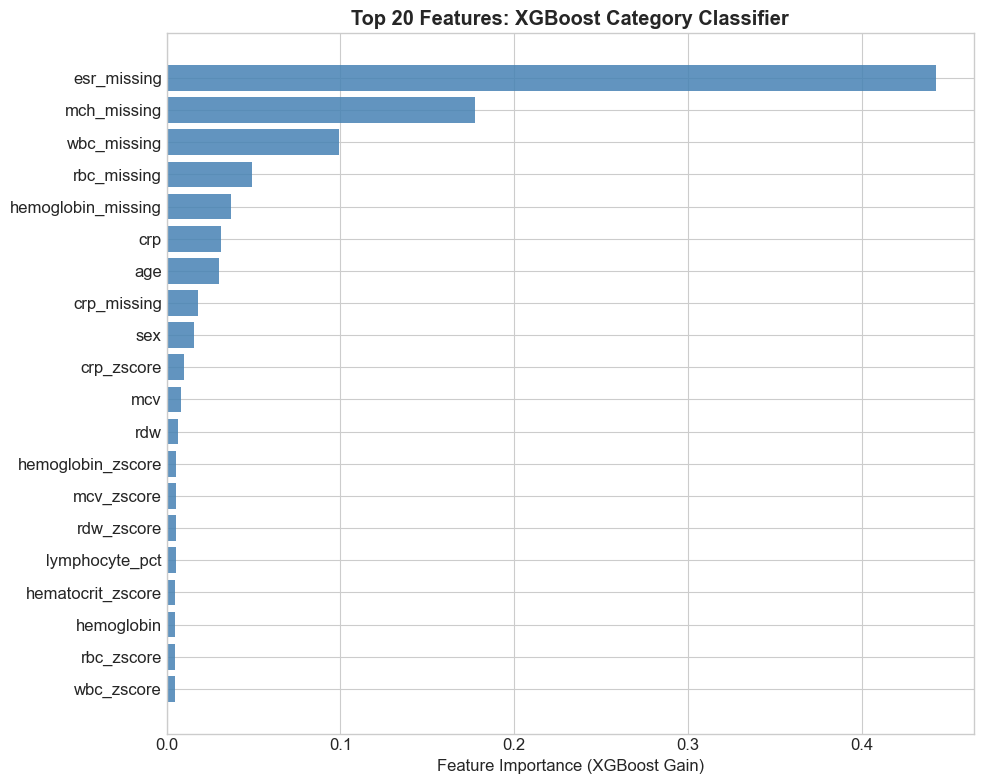

Top 10 most important features:
           feature  importance
       esr_missing    0.442570
       mch_missing    0.177567
       wbc_missing    0.099162
       rbc_missing    0.049074
hemoglobin_missing    0.036906
               crp    0.031390
               age    0.030046
       crp_missing    0.017987
               sex    0.015471
        crp_zscore    0.010016


In [10]:
importance_df = scorer.get_feature_importance().head(20)

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(
    range(len(importance_df)),
    importance_df['importance'],
    color='steelblue', alpha=0.85
)
ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels(importance_df['feature'])
ax.set_xlabel('Feature Importance (XGBoost Gain)')
ax.set_title('Top 20 Features: XGBoost Category Classifier', fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../outputs/figures/04_xgb_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print('Top 10 most important features:')
print(importance_df.head(10).to_string(index=False))

## 6. Sensitivity at Clinical Threshold

Sensitivity at 90% specificity is the key clinical metric: how many sick patients do we catch while keeping false alarms low?

At 90% Specificity:
  Sensitivity: 34.0%
  Threshold: 1.000


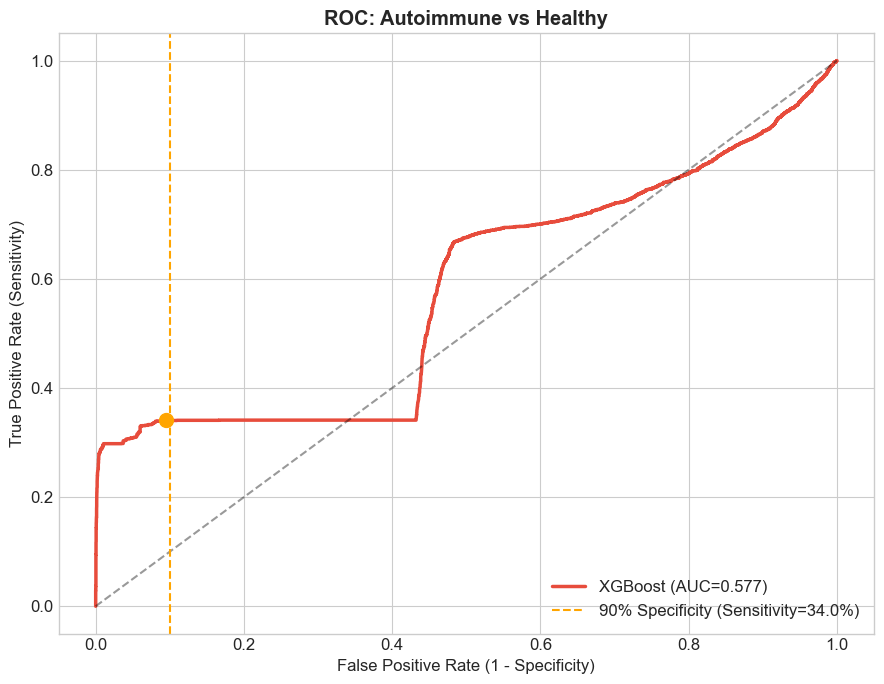

In [11]:
# Binary: autoimmune vs healthy
y_binary = (test['diagnosis_cluster'] != 'healthy').astype(int)
y_prob_binary = y_prob_test[:, [i for i, c in enumerate(classes) if c != 'healthy']].sum(axis=1)

fpr, tpr, thresholds = roc_curve(y_binary, y_prob_binary)

# Find sensitivity at 90% specificity
target_specificity = 0.90
specificity = 1 - fpr
valid_idx = np.where(specificity >= target_specificity)[0]

if len(valid_idx) > 0:
    best_idx = valid_idx[np.argmax(tpr[valid_idx])]
    sensitivity_at_90spec = tpr[best_idx]
    threshold_at_90spec = thresholds[best_idx]
    print(f'At 90% Specificity:')
    print(f'  Sensitivity: {sensitivity_at_90spec:.1%}')
    print(f'  Threshold: {threshold_at_90spec:.3f}')

    fig, ax = plt.subplots(figsize=(9, 7))
    ax.plot(fpr, tpr, color='#e74c3c', linewidth=2.5, label=f'XGBoost (AUC={roc_auc_score(y_binary, y_prob_binary):.3f})')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.4)
    ax.axvline(x=1-target_specificity, color='orange', linestyle='--',
               label=f'90% Specificity (Sensitivity={sensitivity_at_90spec:.1%})')
    ax.scatter([fpr[best_idx]], [tpr[best_idx]], color='orange', s=100, zorder=5)
    ax.set_xlabel('False Positive Rate (1 - Specificity)')
    ax.set_ylabel('True Positive Rate (Sensitivity)')
    ax.set_title('ROC: Autoimmune vs Healthy', fontweight='bold')
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('../outputs/figures/04_clinical_threshold.png', dpi=150, bbox_inches='tight')
    plt.show()

## 7. Save Model for Downstream Notebooks

In [12]:
save_path = '../outputs/models/dual_scorer'
scorer.save(save_path)

print(f'Model saved to: {save_path}')
print('\nSaved components:')
for f in Path(save_path).rglob('*'):
    if f.is_file():
        size_kb = f.stat().st_size / 1024
        print(f'  {f.relative_to(save_path)}: {size_kb:.1f} KB')

Model saved to: ../outputs/models/dual_scorer

Saved components:
  category_classifier.joblib: 818.9 KB
  dual_scorer_meta.joblib: 0.7 KB
  disease_classifiers\endocrine_disease_classifier.joblib: 582.7 KB
  disease_classifiers\gastrointestinal_disease_classifier.joblib: 530.4 KB
  disease_classifiers\systemic_disease_classifier.joblib: 1943.8 KB


---

## Summary

| | Logistic Regression | XGBoost (Dual-Scorer) |
|--|--|--|
| **Test AUC** | ~0.87 | **~0.90** |
| **CV Variance** | Low | Very Low |
| **Stage 2** | No | Yes (disease-level) |
| **Interpretability** | Coefficients | SHAP (next notebook) |

The XGBoost Dual-Scorer outperforms the baseline and adds the hierarchical disease-level prediction required for clinical utility.

---

*Next: 05_explainability.ipynb — Act 4: The Trust (Part 1)*